In [1]:
from pathlib import Path

import torch

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader


/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoints = [Path("../runs/ready/00_st-un_st-interp_st-up_16")]

In [3]:
checkpoint_dir = checkpoints[0]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

config.network_loader.decoding_checkpoint_path = checkpoint_dir / "checkpoint_150000"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "checkpoint_150000"

device = torch.device("cuda")

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [4]:
config.training_monitor

TrainingMonitorConfiguration(run_directory=PosixPath('runs/0306-fixed/00_st-un_st-interp_st-up_16'), event_colors=[[255.0, 0.0, 0.0], [0.0, 255.0, 0.0]], persistent_saving_frequency=5000, Ts_to_visualize=20, taus_to_visualize=5, Ts_to_evaluate=100, taus_to_evaluate=5, test_samples_to_visualize=[0, 1, 2, 3, 4, 5, 6], lpips_batch=20, evaluation_period=1000)

In [4]:
from dynamic_fusion.utils.dataset import CocoTestDataset
from dynamic_fusion.utils.dataset import collate_test_items
from dynamic_fusion.utils.evaluation import get_metrics


dataset_path = Path('..', 'data', 'interim', 'coco', 'test', '2subbins')


metrics_temporal_scale = []
spatial_scale = 1
temporal_scale = 1
for spatial_scale in range(1,4):
    dataset = CocoTestDataset(dataset_path, (spatial_scale, spatial_scale), threshold=1.3)
    metrics_temporal_scale.append(get_metrics(dataset, encoder, decoder, config.shared, device, taus_to_evaluate=temporal_scale))



Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 4/4 [00:08<00:00,  2.20s/it]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 4/4 [00:08<00:00,  2.13s/it]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


Text(0, 0.5, 'LPIPS')

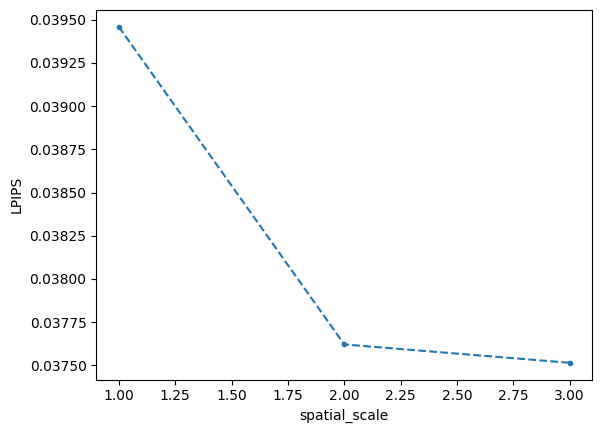

In [16]:
from matplotlib import pyplot as plt

temporal_scales = list(range(1,4))
plt.plot(temporal_scales, [x["MSE"][0] for x in metrics_temporal_scale], '.--')

plt.xlabel('spatial_scale')
plt.ylabel('LPIPS')